In [1]:
from __future__ import print_function

## Genomics example

This will explore how importance scores from three different methods compare on simulated genomic data.

The simulated data was as follows:

- 1/4 sequences with 1-3 instances of a GATA_disc1 motif embedded (see http://compbio.mit.edu/encode-motifs/ for the PWM); these were labelled 1,0,0
- 1/4 sequences with 1-3 instances of a TAL1_known1 motif embedded; these were labelled 0,1,0
- 1/4 sequences with BOTH 1-3 instances of a GATA_disc1 motif AND 1-3 instances of a TAL1_known1 motif; these were labelled 1,1,1
- 1/4 sequences with no motif

Scores for all three tasks for sequences that contain both TAL1_known1 and GATA_disc1 motifs are analyzed in this notebook

## Obtain data and keras model
We will download genomic data and model

### Download the data and model

In [1]:
!./grab_model_and_data.sh

--2020-07-30 17:46:45--  https://raw.githubusercontent.com/AvantiShri/model_storage/db919b12f750e5844402153233249bb3d24e9e9a/deeplift/genomics/sequences.simdata.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.184.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.184.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 629502 (615K) [application/octet-stream]
Saving to: ‘sequences.simdata.gz’

100%[======================================>] 629,502     --.-K/s   in 0.05s   

2020-07-30 17:46:46 (11.8 MB/s) - ‘sequences.simdata.gz’ saved [629502/629502]

--2020-07-30 17:46:46--  https://raw.githubusercontent.com/AvantiShri/model_storage/b6e1d69/deeplift/genomics/keras2_conv1d_record_5_model_PQzyq_modelJson.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.184.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.184.133|:443... connected.
HTTP request

### Read in and one-hot encode the data

The simdna package is needed for reading the data; install it if it doesn't exist

In [2]:
#
try:
    import simdna
except :
    print("installing simdna package")
    !pip install -e "git://github.com/kundajelab/simdna.git@0.4.0#egg=simdna"
    print("\n******************************************************************************")
    print("RESTART THE JUPYTER KERNEL TO PICK UP ON THE INSTALLATION!!!")
    print("******************************************************************************")

SyntaxError: invalid syntax (<ipython-input-2-0d91594b29b9>, line 3)

Read in data

In [ ]:
import simdna.synthetic as synthetic
import imp

imp.reload(synthetic)
imp.reload(synthetic.core)
import gzip
data_filename = "sequences.simdata"

In [10]:
#read in the data in the testing set
test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = [x.decode().rstrip("\n") for x in test_ids_fh]

In [16]:
data = synthetic.read_simdata_file(data_filename, ids_to_load=ids_to_load)

One-hot encode the data

In [22]:
import numpy as np

#this is set up for 1d convolutions where examples
#have dimensions (len, num_channels)
#the channel axis is the axis for one-hot encoding.
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
            
onehot_data = np.array([one_hot_encode_along_channel_axis(seq) for seq in data.sequences])

In [73]:
onehot_data.shape

(800, 200, 4)

### Load the keras model

In [24]:
import deeplift
from keras.models import model_from_json

#load the keras model
keras_model_weights = "keras2_conv1d_record_5_model_PQzyq_modelWeights.h5"
keras_model_json = "keras2_conv1d_record_5_model_PQzyq_modelJson.json"

keras_model = model_from_json(open(keras_model_json).read())
keras_model.load_weights(keras_model_weights)

Using TensorFlow backend.


/users/PCCH0011/cch0017/anaconda3/envs/gpu/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  """


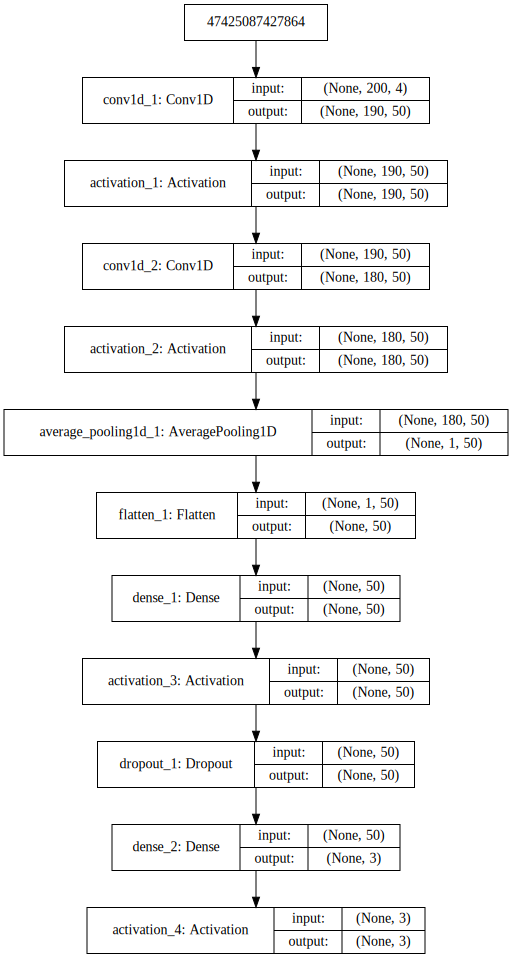

In [67]:
from IPython.display import SVG, display
from keras.utils.vis_utils import plot_model
from keras.utils.vis_utils import model_to_dot
import matplotlib
matplotlib.use('agg')
import matplotlib.pylab as plt
class keras_visual():
    @staticmethod
    def plot_n_display(keras_model, output_file_path):
        plot_model(model=keras_model,
                   to_file=os.path.join(output_file_path, 'model.pdf'),
                   show_shapes=True)
        # visualize in notebook view
        display(SVG(model_to_dot(keras_model, show_shapes=True).create(prog='dot', format='svg')))
    @staticmethod
    def plot(keras_model, output_file_path, output_file_name):
        plot_model(model=keras_model,
                   to_file=os.path.join(output_file_path, output_file_name),
                   show_shapes=True)
    @staticmethod
    def display(keras_model):
        display(SVG(model_to_dot(keras_model, show_shapes=True).create(prog='dot', format='svg')))


keras_visual.plot_n_display(keras_model=keras_model,output_file_path='./')


In [68]:
keras_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 190, 50)           2250      
_________________________________________________________________
activation_1 (Activation)    (None, 190, 50)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 180, 50)           27550     
_________________________________________________________________
activation_2 (Activation)    (None, 180, 50)           0         
_________________________________________________________________
average_pooling1d_1 (Average (None, 1, 50)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
__________

## Prepare the deeplift models

### Model conversion

Convert the keras models to deeplift models capable of computing importance scores using DeepLIFT (with 3 different variants:
##### a) rescale on the conv layers and revealcancel on the fully-connected layers (the genomics default), 
##### b) rescale on all layers, and revealcancel on all layers), 
##### c) gradients and guided backprop


In [26]:
from deeplift.layers import NonlinearMxtsMode
import deeplift.conversion.kerasapi_conversion as kc
imp.reload(deeplift.layers)
imp.reload(deeplift.conversion.kerasapi_conversion)
from collections import OrderedDict

method_to_model = OrderedDict()
for method_name, nonlinear_mxts_mode in [
    #The genomics default = rescale on conv layers, revealcancel on fully-connected
    ('rescale_conv_revealcancel_fc', NonlinearMxtsMode.DeepLIFT_GenomicsDefault),
    ('rescale_all_layers', NonlinearMxtsMode.Rescale),
    ('revealcancel_all_layers', NonlinearMxtsMode.RevealCancel),
    ('grad_times_inp', NonlinearMxtsMode.Gradient),
    ('guided_backprop', NonlinearMxtsMode.GuidedBackprop)]:
    method_to_model[method_name] = kc.convert_model_from_saved_files(
        h5_file=keras_model_weights,
        json_file=keras_model_json,
        nonlinear_mxts_mode=nonlinear_mxts_mode)

nonlinear_mxts_mode is set to: DeepLIFT_GenomicsDefault
For layer 1 the preceding linear layer is 0 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 3 the preceding linear layer is 2 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 7 the preceding linear layer is 6 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel
Heads-up: I assume sigmoid is the output layer, not an intermediate one; if it's an intermediate layer then please bug me and I will implement the grad func
For layer 10 the preceding linear layer is 9 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel
nonlinear_mxts_mode is set to: Rescale
Heads-up: I assume sigmoid is the output layer, not a

### Sanity checks
To ensure that the conversion happend correctly, ensure that the models give identical predictions

If you are using a functional model, see this issue for how to adapt the code: 
https://github.com/kundajelab/deeplift/issues/54 
#### Will need the above modification

In [27]:
#make sure predictions are the same as the original model
from deeplift.util import compile_func
model_to_test = method_to_model['rescale_conv_revealcancel_fc']
deeplift_prediction_func = compile_func([model_to_test.get_layers()[0].get_activation_vars()],
                                         model_to_test.get_layers()[-1].get_activation_vars())
original_model_predictions = keras_model.predict(onehot_data, batch_size=200)
converted_model_predictions = deeplift.util.run_function_in_batches(
                                input_data_list=[onehot_data],
                                func=deeplift_prediction_func,
                                batch_size=200,
                                progress_update=None)
print("maximum difference in predictions:",np.max(np.array(converted_model_predictions)-np.array(original_model_predictions)))
assert np.max(np.array(converted_model_predictions)-np.array(original_model_predictions)) < 10**-5
predictions = converted_model_predictions

maximum difference in predictions: 0.0


## Compute importance scores

### Compile various scoring functions
Using the deeplift models, we obtain the functions capable of computing the importance scores.

In [28]:
print("Compiling scoring functions")
method_to_scoring_func = OrderedDict()
for method,model in method_to_model.items():
    print("Compiling scoring function for: "+method)
    method_to_scoring_func[method] = model.get_target_contribs_func(find_scores_layer_idx=0,
                                                                    target_layer_idx=-2)
    
#To get a function that just gives the gradients, we use the multipliers of the Gradient model
gradient_func = method_to_model['grad_times_inp'].get_target_multipliers_func(find_scores_layer_idx=0,
                                                                              target_layer_idx=-2)
print("Compiling integrated gradients scoring functions")
integrated_gradients10_func = deeplift.util.get_integrated_gradients_function(
    gradient_computation_function = gradient_func,
    num_intervals=10)
method_to_scoring_func['integrated_gradients10'] = integrated_gradients10_func

Compiling scoring functions
Compiling scoring function for: rescale_conv_revealcancel_fc
TARGET LAYER SET TO 9
Compiling scoring function for: rescale_all_layers
TARGET LAYER SET TO 9
Compiling scoring function for: revealcancel_all_layers
TARGET LAYER SET TO 9
Compiling scoring function for: grad_times_inp
TARGET LAYER SET TO 9
Compiling scoring function for: guided_backprop
TARGET LAYER SET TO 9
TARGET LAYER SET TO 9
Compiling integrated gradients scoring functions


In [74]:
np.array([background['A'],
                               background['C'],
                               background['G'],
                               background['T']])[None,None,:]

array([[[0.3, 0.2, 0.2, 0.3]]])

In [76]:
method_to_scoring_func['grad_times_inp']

<function deeplift.models.Model._get_func.<locals>.func(task_idx, input_data_list, batch_size, progress_update, input_references_list=None)>

### Call scoring functions on the data

In the cell below, a reference representing 40% GC content is used

In [29]:
background = OrderedDict([('A', 0.3), ('C', 0.2), ('G', 0.2), ('T', 0.3)])

from collections import OrderedDict
method_to_task_to_scores = OrderedDict()
for method_name, score_func in method_to_scoring_func.items():
    print("on method",method_name)
    method_to_task_to_scores[method_name] = OrderedDict()
    for task_idx in [0,1,2]:
        scores = np.array(score_func(
                    task_idx=task_idx,
                    input_data_list=[onehot_data],
                    input_references_list=[
                     np.array([background['A'],
                               background['C'],
                               background['G'],
                               background['T']])[None,None,:]],
                    batch_size=200,
                    progress_update=None))
        assert scores.shape[2]==4
        #The sum over the ACGT axis in the code below is important! Recall that DeepLIFT
        # assigns contributions based on difference-from-reference; if
        # a position is [1,0,0,0] (i.e. 'A') in the actual sequence and [0.3, 0.2, 0.2, 0.3]
        # in the reference, importance will be assigned to the difference (1-0.3)
        # in the 'A' channel, (0-0.2) in the 'C' channel,
        # (0-0.2) in the G channel, and (0-0.3) in the T channel. You want to take the importance
        # on all four channels and sum them up, so that at visualization-time you can project the
        # total importance over all four channels onto the base that is actually present (i.e. the 'A'). If you
        # don't do this, your visualization will look very confusing as multiple bases will be highlighted at
        # every position and you won't know which base is the one that is actually present in the sequence!
        scores = np.sum(scores, axis=2)
        method_to_task_to_scores[method_name][task_idx] = scores

on method rescale_conv_revealcancel_fc
on method rescale_all_layers
on method revealcancel_all_layers
on method grad_times_inp
on method guided_backprop
on method integrated_gradients10


## Using multiple shuffled references

As an alternative to using a flat reference based on GC content (which can sometimes produce artefacts), we propose averaging the scores produced using mutliple references which are produced by shuffling the original sequence. We find in practice that this can give more robust results. Note that in general, the optimal choice of reference is an area of active research.

In [77]:
rescale_conv_revealcancel_fc_many_refs_func

<function deeplift.util.get_shuffle_seq_ref_function.<locals>.compute_scores_with_shuffle_seq_refs(task_idx, input_data_sequences, num_refs_per_seq, batch_size, seed=1, progress_update=None)>

In [31]:
imp.reload(deeplift.util)
from deeplift.util import get_shuffle_seq_ref_function
#from deeplift.util import randomly_shuffle_seq
from deeplift.dinuc_shuffle import dinuc_shuffle #function to do a dinucleotide shuffle

rescale_conv_revealcancel_fc_many_refs_func = get_shuffle_seq_ref_function(
    #score_computation_function is the original function to compute scores
    score_computation_function=method_to_scoring_func['rescale_conv_revealcancel_fc'],
    #shuffle_func is the function that shuffles the sequence
    #technically, given the background of this simulation, randomly_shuffle_seq
    #makes more sense. However, on real data, a dinuc shuffle is advisable due to
    #the strong bias against CG dinucleotides
    shuffle_func=dinuc_shuffle,
    one_hot_func=lambda x: np.array([one_hot_encode_along_channel_axis(seq) for seq in x]))

num_refs_per_seq=10 #number of references to generate per sequence
method_to_task_to_scores['rescale_conv_revealcancel_fc_multiref_'+str(num_refs_per_seq)] = OrderedDict()
for task_idx in [0,1,2]:
    #The sum over the ACGT axis in the code below is important! Recall that DeepLIFT
    # assigns contributions based on difference-from-reference; if
    # a position is [1,0,0,0] (i.e. 'A') in the actual sequence and [0, 1, 0, 0]
    # in the reference, importance will be assigned to the difference (1-0)
    # in the 'A' channel, and (0-1) in the 'C' channel. You want to take the importance
    # on all channels and sum them up, so that at visualization-time you can project the
    # total importance over all four channels onto the base that is actually present (i.e. the 'A'). If you
    # don't do this, your visualization will look very confusing as multiple bases will be highlighted at
    # every position and you won't know which base is the one that is actually present in the sequence!
    method_to_task_to_scores['rescale_conv_revealcancel_fc_multiref_'+str(num_refs_per_seq)][task_idx] =\
        np.sum(
            rescale_conv_revealcancel_fc_many_refs_func(
                task_idx=task_idx,
                input_data_sequences=data.sequences,
                num_refs_per_seq=num_refs_per_seq,
                batch_size=200,
                progress_update=1000,
            ),
            axis=2
        )

1000 reference seqs generated
2000 reference seqs generated
3000 reference seqs generated
4000 reference seqs generated
5000 reference seqs generated
6000 reference seqs generated
7000 reference seqs generated
8000 reference seqs generated
One hot encoding sequences...
One hot encoding done...
Done 0
Done 1000
Done 2000
Done 3000
Done 4000
Done 5000
Done 6000
Done 7000
1000 reference seqs generated
2000 reference seqs generated
3000 reference seqs generated
4000 reference seqs generated
5000 reference seqs generated
6000 reference seqs generated
7000 reference seqs generated
8000 reference seqs generated
One hot encoding sequences...
One hot encoding done...
Done 0
Done 1000
Done 2000
Done 3000
Done 4000
Done 5000
Done 6000
Done 7000
1000 reference seqs generated
2000 reference seqs generated
3000 reference seqs generated
4000 reference seqs generated
5000 reference seqs generated
6000 reference seqs generated
7000 reference seqs generated
8000 reference seqs generated
One hot encoding

## Visualize scores on individual sequences

Visualize the scores at specific sequences. Cyan boxes indicate the ground-truth locations of the inserted TAL1_known1 motifs, red boxes indicate the ground-truth locations of the inserted GATA_disc1 motifs

Scores for task 0 for example 731
rescale_conv_revealcancel_fc


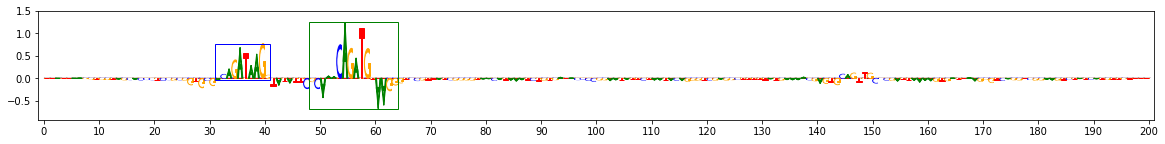

Scores for task 1 for example 197
rescale_conv_revealcancel_fc


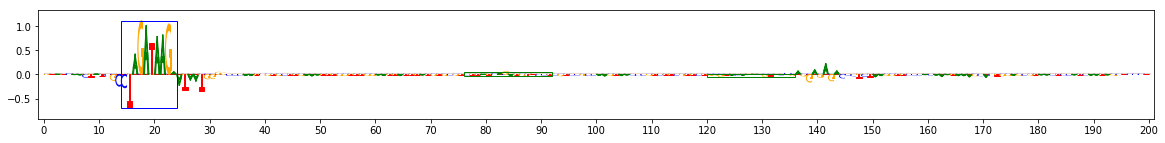

In [39]:
#visualize scores + ground-truth locations of motifs
%matplotlib inline
from deeplift.visualization import viz_sequence

for task, idx in [(0,731), #illustrates failure of grad*inp, integrated grads, deeplift-rescale
                  (1,197)  #illustrates non-specific firing of guided backprop
                 ]:
    
    print("Scores for task",task,"for example",idx)
    for method_name in [
                        #'grad_times_inp',
                        #'guided_backprop',
                        #'integrated_gradients10',
                        #'rescale_all_layers', 
                        #'revealcancel_all_layers',
                        'rescale_conv_revealcancel_fc',
                        #'rescale_conv_revealcancel_fc_multiref_10'
                        ]:
        scores = method_to_task_to_scores[method_name][task]
        scores_for_idx = scores[idx]
        original_onehot = onehot_data[idx]
        scores_for_idx = original_onehot*scores_for_idx[:,None]
        print(method_name)
        highlight = {'blue':[
                (embedding.startPos, embedding.startPos+len(embedding.what))
                for embedding in data.embeddings[idx] if 'GATA_disc1' in embedding.what.getDescription()],
                'green':[
                (embedding.startPos, embedding.startPos+len(embedding.what))
                for embedding in data.embeddings[idx] if 'TAL1_known1' in embedding.what.getDescription()]}
        viz_sequence.plot_weights(scores_for_idx, subticks_frequency=10, highlight=highlight)

In [ ]:
viz_sequence.plot_weights()

In [80]:
scores = method_to_task_to_scores['rescale_conv_revealcancel_fc'][1]
scores.shape

(800, 200)

In [64]:
scores_for_idx = scores[731]
original_onehot = onehot_data[731]
scores_for_idx = original_onehot*scores_for_idx[:,None]

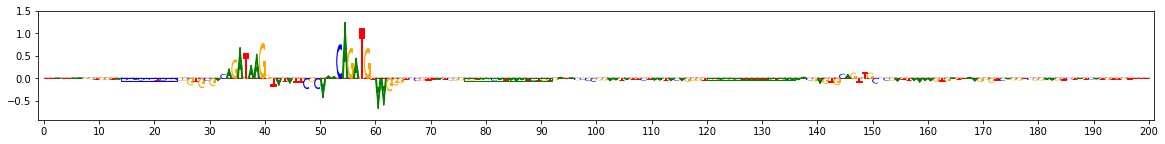

In [65]:
viz_sequence.plot_weights(scores_for_idx, subticks_frequency=10, highlight=highlight)

In [66]:
scores_for_idx.shape

(200, 4)

In [54]:
scores.shape

(800, 200)

In [55]:
original_onehot.shape

(200, 4)

In [56]:
scores_for_idx = original_onehot*scores_for_idx[:,None]

In [57]:
scores_for_idx.shape

(200, 200, 4)

In [51]:
scores_for_idx[197,30:60]

array([], dtype=float32)

## Making the scatterplots

I haven't ported the code necessary to generate the scatterplots in the DeepLIFT paper in this version of DeepLIFT. However, for a notebook that reproduces the figures in the paper, feel free to look at https://github.com/kundajelab/deeplift/blob/671ee67a03bd5bebf4c405af59eec45d3ca2a288/examples/public/genomics/genomics_simulation.ipynb